In [5]:
print("kiofendfr")

kiofendfr


Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing counts (post-imputation):
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


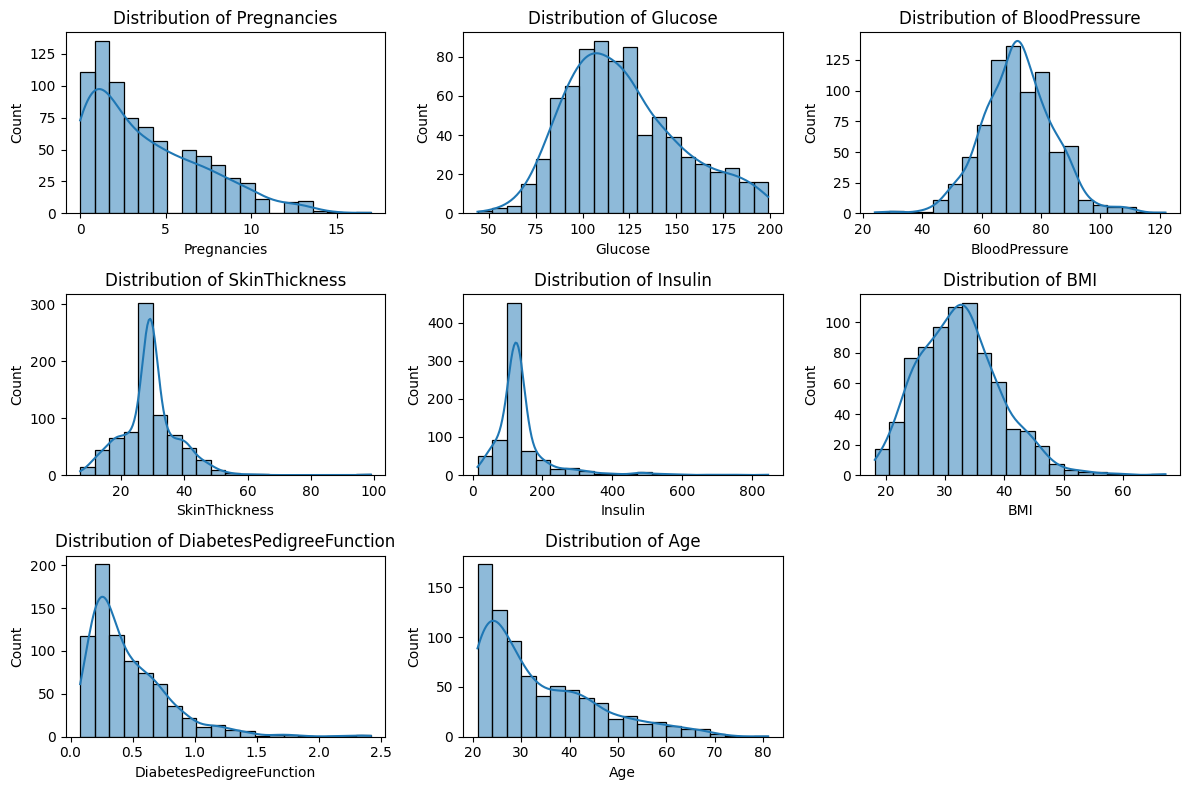

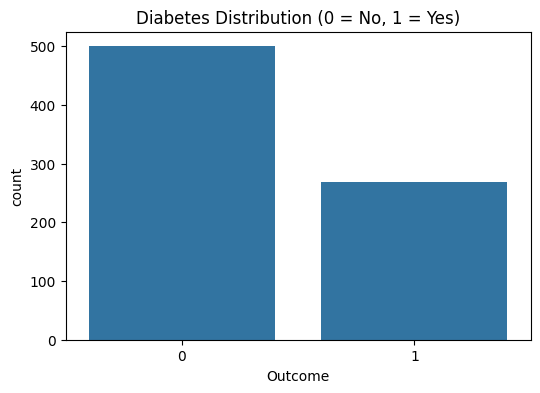


Training samples: 614, Testing samples: 154

Training LogisticRegression...

Training RandomForest...

Training AdaBoost...

Training Decision Tree...

Training Gradient Boosting...

Training SVM (RBF Kernel)...

🔍 Tuning MLAR hyperparameters... (this may take a few minutes)
Checking 1/24: lr=0.01, epochs=3000, pos_weight=1.0, l2=0.0 ... f1=0.0000
Checking 2/24: lr=0.01, epochs=3000, pos_weight=1.0, l2=0.0001 ... f1=0.0000
Checking 3/24: lr=0.01, epochs=3000, pos_weight=1.5, l2=0.0 ... f1=0.5287
Checking 4/24: lr=0.01, epochs=3000, pos_weight=1.5, l2=0.0001 ... f1=0.5287
Checking 5/24: lr=0.01, epochs=3000, pos_weight=2.0, l2=0.0 ... f1=0.6347
Checking 6/24: lr=0.01, epochs=3000, pos_weight=2.0, l2=0.0001 ... f1=0.6347
Checking 7/24: lr=0.01, epochs=5000, pos_weight=1.0, l2=0.0 ... f1=0.0000
Checking 8/24: lr=0.01, epochs=5000, pos_weight=1.0, l2=0.0001 ... f1=0.0000
Checking 9/24: lr=0.01, epochs=5000, pos_weight=1.5, l2=0.0 ... f1=0.5474
Checking 10/24: lr=0.01, epochs=5000, pos_wei

<Figure size 1000x600 with 0 Axes>

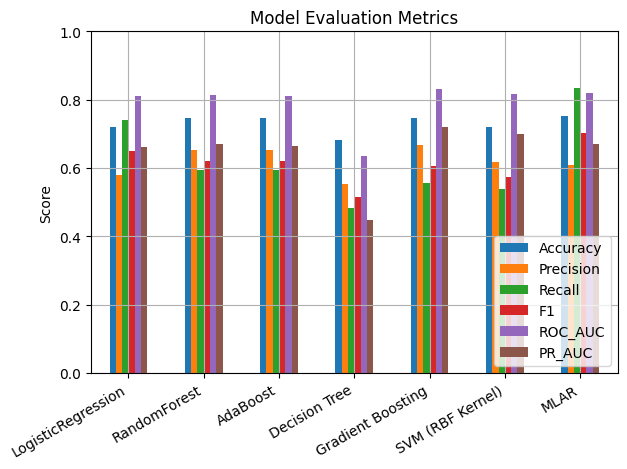

<Figure size 800x400 with 0 Axes>

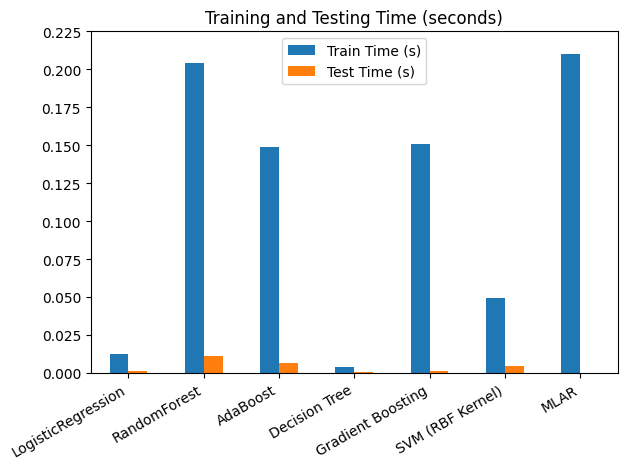


📊 Final Numeric Comparison of All Models (Rounded to 4 decimals):

                    Accuracy  Precision    Recall        F1   ROC_AUC    PR_AUC  Train Time (s)  Test Time (s)
LogisticRegression  0.720779   0.579710  0.740741  0.650407  0.811852  0.661641        0.012700       0.000943
RandomForest        0.746753   0.653061  0.592593  0.621359  0.815000  0.669695        0.204029       0.010861
AdaBoost            0.746753   0.653061  0.592593  0.621359  0.809630  0.664885        0.148840       0.006256
Decision Tree       0.681818   0.553191  0.481481  0.514851  0.635741  0.448170        0.003831       0.000639
Gradient Boosting   0.746753   0.666667  0.555556  0.606061  0.830185  0.720600        0.150850       0.000934
SVM (RBF Kernel)    0.720779   0.617021  0.537037  0.574257  0.817222  0.699274        0.049578       0.004395
MLAR                0.753247   0.608108  0.833333  0.703125  0.819630  0.671124        0.210199       0.000011


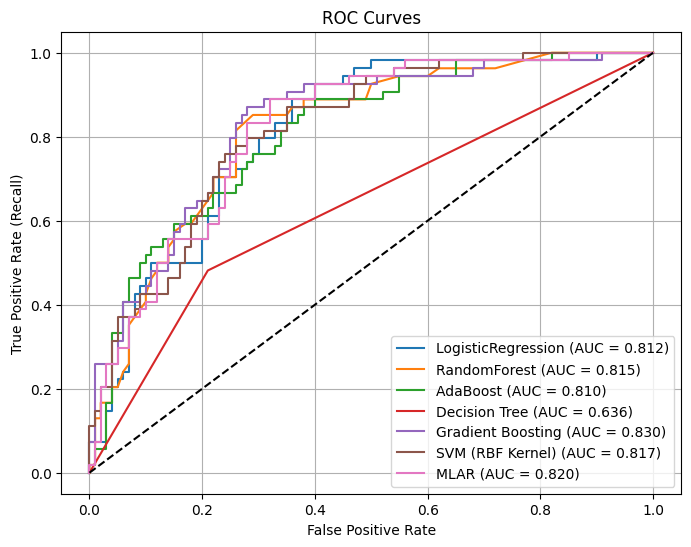

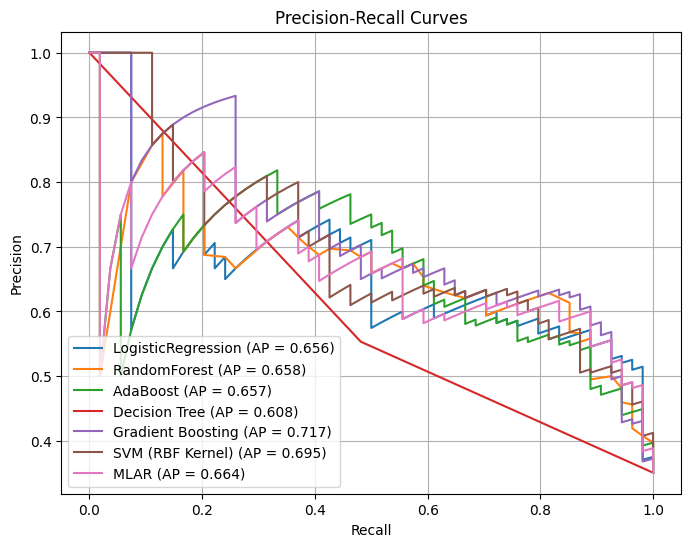

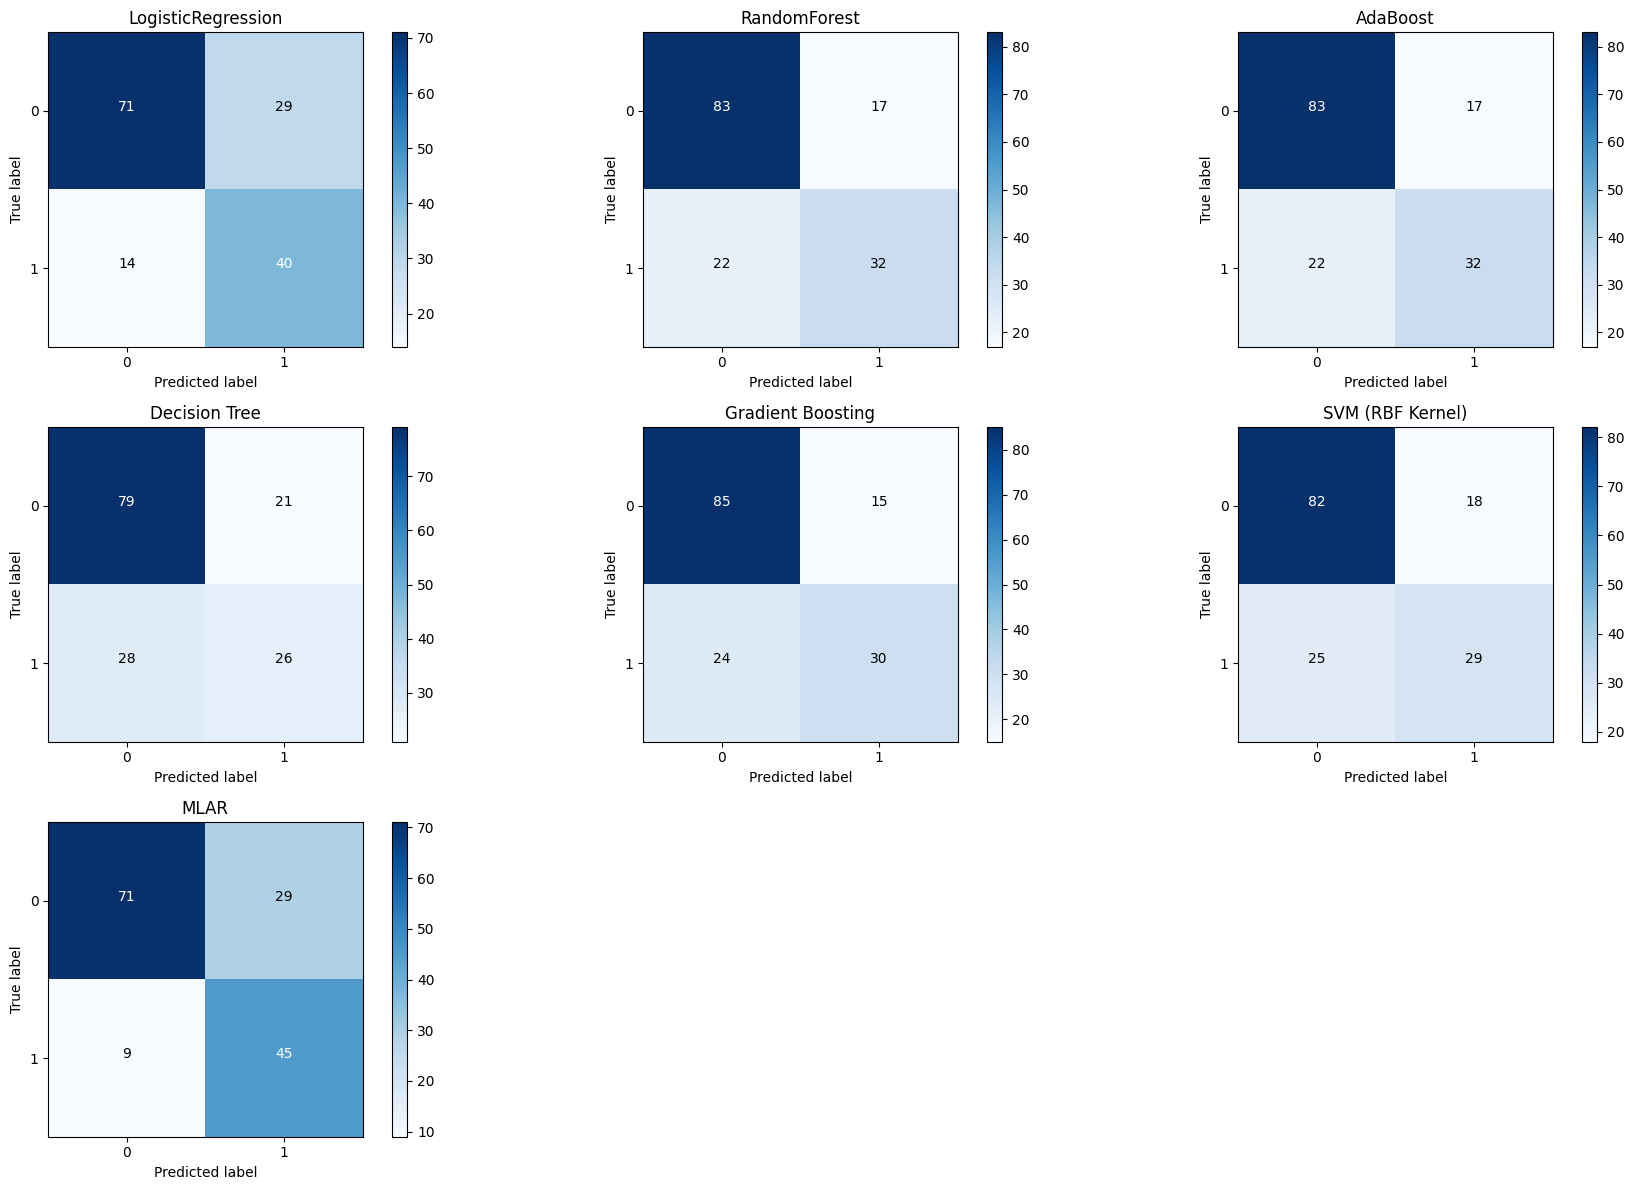

In [6]:

# =============================


import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from time import perf_counter as now 

from sklearn.model_selection import train_test_split, StratifiedKFold # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ( # type: ignore
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc, confusion_matrix
)
import itertools

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# =============================
# Load Dataset
# =============================
data = pd.read_csv("PIMA_diabetes_Dataset.csv")
print("Dataset shape:", data.shape)
print(data.head())

# =============================
# Data Cleaning
# Replace 0 with NaN for selected columns
# =============================
cols_maybe_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for c in cols_maybe_zero_missing:
    data[c] = data[c].replace(0, np.nan)

# Fill missing with median
for c in cols_maybe_zero_missing:
    data[c].fillna(data[c].median(), inplace=True)

# Optional: show missing counts
print("\nMissing counts (post-imputation):")
print(data[cols_maybe_zero_missing].isna().sum())

# =============================
# Data Visualization
# =============================
plt.figure(figsize=(12, 8))
for idx, col in enumerate(data.columns[:-1]):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="Outcome", data=data)
plt.title("Diabetes Distribution (0 = No, 1 = Yes)")
plt.show()


# =============================
# Feature Engineering & Scaling
# =============================
features = data.drop(columns="Outcome")
labels = data["Outcome"]

# log-transform skewed features (after imputation)
skewed = ['Insulin', 'SkinThickness', 'Glucose', 'BMI']
for c in skewed:
    # log1p is safe for zeros (though we've imputed)
    features[c] = np.log1p(features[c])

# Split dataset (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)

print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Scale features (fit on train only)
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_to_scale = X_train.columns
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

# Convert to numpy for MLAR and timing uses
X_train_np = X_train_scaled.values
X_test_np  = X_test_scaled.values
y_train_np = y_train.values.reshape(-1,1)
y_test_np  = y_test.values.reshape(-1,1)

# =============================
# Utility functions: timing & evaluation
# =============================
def measure_test_time(func, X, repeats=1000):
    """Repeat predictions to get stable average test time per call."""
    start = now()
    for _ in range(repeats):
        _ = func(X)
    end = now()
    return (end - start) / repeats

def evaluate_model(name, model, X_train, y_train, X_test, y_test, test_repeats=1000):
    # Train time
    start_train = now()
    model.fit(X_train, y_train)
    end_train = now()
    train_time = end_train - start_train

    # Predictions (single run for metrics)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    # Test time (averaged for stability)
    test_time = measure_test_time(lambda X: model.predict(X), X_test, repeats=test_repeats)

    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        "PR_AUC": average_precision_score(y_test, y_proba) if y_proba is not None else np.nan,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time
    }
    return results

# =============================
# Train Baseline Models
# =============================
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE), random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

metrics_summary = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    metrics_summary[name] = evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test, test_repeats=1000)

# =============================
# Custom MLAR (Modified Logistic Regression)
# =============================
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_mlar(X, W, b, threshold=0.5):
    probs = sigmoid(X @ W + b).ravel()
    return (probs >= threshold).astype(int), probs

def MLAR(X, y, lr=0.1, epochs=2000, pos_weight=2.0, l2=0.0, seed=RANDOM_STATE):
    np.random.seed(seed)
    m, n = X.shape
    W = np.random.randn(n, 1) * 0.01
    b = 0.0

    for i in range(epochs):
        z = X @ W + b
        y_hat = sigmoid(z)
        y_hat = np.clip(y_hat, 1e-9, 1 - 1e-9)

        # class weights (boost positives)
        w = np.where(y == 1, pos_weight, 1.0)

        # gradient
        dz = (y_hat - y) * w
        dW = (1/m) * (X.T @ dz) + (l2/m) * W
        db = (1/m) * np.sum(dz)

        # learning rate schedule
        lr_i = lr / (1 + 0.001 * i)
        W -= lr_i * dW
        b -= lr_i * db

    return W, b

# =============================
# Hyperparameter Tuning for MLAR (manual grid search)
# =============================
def tune_mlar(X_train, y_train, X_val, y_val, param_grid=None, verbose=False):
    if param_grid is None:
        param_grid = {
            "lr": [0.01, 0.05, 0.1],
            "epochs": [3000, 5000],
            "pos_weight": [1.0, 1.5, 2.0],
            "l2": [0.0, 1e-4, 1e-3]
        }

    best_score = -1
    best_params = None
    best_results = None
    best_W, best_b = None, None

    total = 1
    for v in param_grid.values():
        total *= len(v)
    checked = 0

    for lr in param_grid["lr"]:
        for epochs in param_grid["epochs"]:
            for pos_weight in param_grid["pos_weight"]:
                for l2 in param_grid["l2"]:
                    checked += 1
                    if verbose:
                        print(f"Checking {checked}/{total}: lr={lr}, epochs={epochs}, pos_weight={pos_weight}, l2={l2} ...", end=" ")
                    W, b = MLAR(X_train, y_train, lr=lr, epochs=epochs, pos_weight=pos_weight, l2=l2)
                    y_pred, y_proba = predict_mlar(X_val, W, b)
                    f1 = f1_score(y_val.ravel(), y_pred, zero_division=0)
                    roc_auc = roc_auc_score(y_val.ravel(), y_proba)
                    if f1 > best_score:
                        best_score = f1
                        best_params = {"lr": lr, "epochs": epochs, "pos_weight": pos_weight, "l2": l2}
                        best_results = {
                            "Accuracy": accuracy_score(y_val.ravel(), y_pred),
                            "Precision": precision_score(y_val.ravel(), y_pred, zero_division=0),
                            "Recall": recall_score(y_val.ravel(), y_pred, zero_division=0),
                            "F1": f1,
                            "ROC_AUC": roc_auc,
                            "PR_AUC": average_precision_score(y_val.ravel(), y_proba)
                        }
                        best_W, best_b = W, b
                    if verbose:
                        print(f"f1={f1:.4f}")

    return best_params, best_results, best_W, best_b

# Run tuning on our train/test split (we're using test as validation here for simplicity)
print("\n🔍 Tuning MLAR hyperparameters... (this may take a few minutes)")
param_grid = {
    "lr": [0.01, 0.05],
    "epochs": [3000, 5000],
    "pos_weight": [1.0, 1.5, 2.0],
    "l2": [0.0, 1e-4]
}
best_params, best_results, W_mlar_best, b_mlar_best = tune_mlar(X_train_np, y_train_np, X_test_np, y_test_np, param_grid=param_grid, verbose=True)

print("\nBest MLAR parameters:", best_params)
print("Best MLAR results (on validation/test):", best_results)

# =============================
# Evaluate MLAR with timing
# =============================
# Retrain MLAR with best params on training data
start_train = now()
W_mlar, b_mlar = MLAR(X_train_np, y_train_np,
                      lr=best_params["lr"],
                      epochs=best_params["epochs"],
                      pos_weight=best_params["pos_weight"],
                      l2=best_params["l2"])
end_train = now()
train_time = end_train - start_train

# Predictions once for metrics
y_pred_mlar, y_proba_mlar = predict_mlar(X_test_np, W_mlar, b_mlar)

# Define wrapper that ensures prediction outputs are used
def predict_wrapper(X):
    y_pred, _ = predict_mlar(X, W_mlar, b_mlar)
    return y_pred

# Average test time (stable)
test_time = measure_test_time(predict_wrapper, X_test_np, repeats=5000)

metrics_summary["MLAR"] = {
    "Accuracy": accuracy_score(y_test_np.ravel(), y_pred_mlar),
    "Precision": precision_score(y_test_np.ravel(), y_pred_mlar, zero_division=0),
    "Recall": recall_score(y_test_np.ravel(), y_pred_mlar, zero_division=0),
    "F1": f1_score(y_test_np.ravel(), y_pred_mlar, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test_np.ravel(), y_proba_mlar),
    "PR_AUC": average_precision_score(y_test_np.ravel(), y_proba_mlar),
    "Train Time (s)": train_time,
    "Test Time (s)": test_time
}

# =============================
# Final Evaluation Summary
# =============================
metrics_df = pd.DataFrame(metrics_summary).T
print("\n📌 Final Evaluation Summary:")
print(metrics_df.round(6))

# =============================
# Plot Metrics & Curves
# =============================
plt.figure(figsize=(10,6))
metrics_df[['Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC']].plot(kind='bar')
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=30 , ha='right')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Train/Test times
plt.figure(figsize=(8,4))
metrics_df[['Train Time (s)','Test Time (s)']].plot(kind='bar')
plt.title("Training and Testing Time (seconds)")
plt.xticks(rotation=30, ha ='right')
# ✅ Add this line
plt.yticks(np.arange(0, metrics_df[['Train Time (s)','Test Time (s)']].values.max() + 0.025, 0.025))

plt.tight_layout()
plt.show()
# =========================================
# Print Final Comparison in Numeric Form
# =========================================
print("\n📊 Final Numeric Comparison of All Models (Rounded to 4 decimals):\n")
print(metrics_df[['Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC',
                  'Train Time (s)','Test Time (s)']].round(6).to_string())

# ROC & PR curves
probas = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probas[name] = model.predict_proba(X_test_scaled)[:,1]
probas["MLAR"] = y_proba_mlar

plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AP = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Confusion Matrices for All Models
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion(cm, labels, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ✅ Updated plotting section
num_models = len(models) + 1  # +1 for MLAR
cols = 3  # number of columns in grid
rows = (num_models + cols - 1) // cols  # automatically determine rows

plt.figure(figsize=(6 * cols, 4 * rows))

i = 1
for name, model in models.items():
    plt.subplot(rows, cols, i)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, labels=[0, 1], title=name)
    i += 1

# Add MLAR confusion matrix
plt.subplot(rows, cols, i)
cm = confusion_matrix(y_test, y_pred_mlar)
plot_confusion(cm, labels=[0, 1], title="MLAR")

plt.tight_layout()
plt.show()


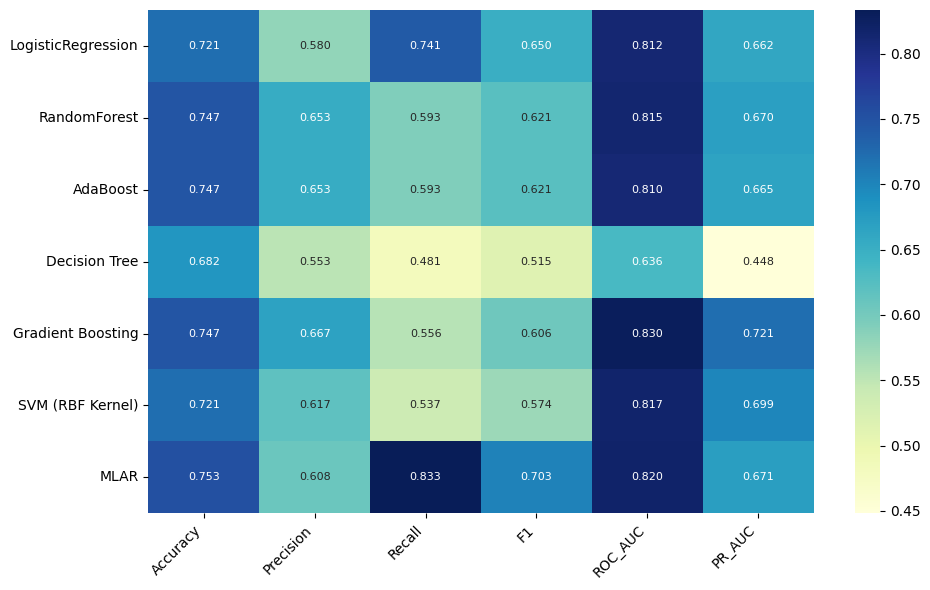

In [7]:
# Heat Map



## Heatmap of Metrics
plt.figure(figsize=(10, 6))  # Increase figure size

sns.heatmap(
    metrics_df[['Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC']].round(4),
    annot=True,
    cmap="YlGnBu",
    annot_kws={"size": 8},   # Reduce text size
    fmt=".3f"                # Decimal formatting to avoid too many digits
)

plt.xticks(rotation=45, ha='right')  # Tilt x-axis labels
plt.yticks(rotation=0)               # Keep model names readable
plt.tight_layout()                   # Avoid crowds
plt.show()




<Axes: >

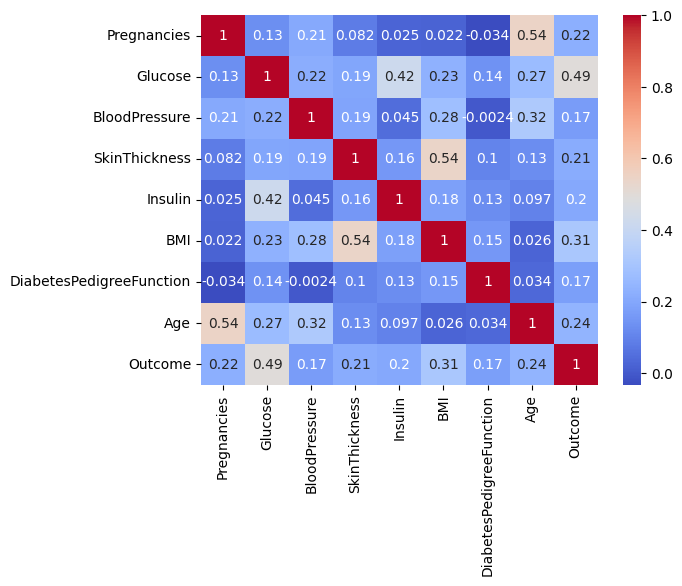

In [8]:
## Heatmap of the dataset

sns.heatmap(data.corr(), annot=True, cmap="coolwarm")


▶ Evaluating Feature: Insulin

🔹 Running MLAR for feature: Insulin

▶ Evaluating Feature: BMI

🔹 Running MLAR for feature: BMI

▶ Evaluating Feature: Glucose

🔹 Running MLAR for feature: Glucose

▶ Evaluating Feature: SkinThickness

🔹 Running MLAR for feature: SkinThickness

📊 Feature-wise Comparison Summary:



,Feature,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,Train Time (s),Test Time (s)
0,Insulin,LogisticRegression,0.61039,0.40625,0.24074,0.30233,0.57972,0.41563,0.00753,0.00008
1,Insulin,RandomForest,0.46753,0.36792,0.72222,0.48750,0.51528,0.35873,0.18628,0.00896
2,Insulin,AdaBoost,0.60390,0.33333,0.12963,0.18667,0.57463,0.39760,0.07185,0.00461
3,Insulin,Decision Tree,0.59091,0.28571,0.11111,0.16000,0.50565,0.36037,0.00098,0.00008
4,Insulin,Gradient Boosting,0.58442,0.27273,0.11111,0.15789,0.55426,0.38200,0.07755,0.00032
5,Insulin,SVM (RBF Kernel),0.62338,0.38889,0.12963,0.19444,0.58537,0.41148,0.04906,0.00432
6,Insulin,MLAR,0.44805,0.38168,0.92593,0.54054,0.57972,0.41563,NaN,0.00001
7,BMI,LogisticRegression,0.60390,0.44444,0.51852,0.47863,0.66167,0.45803,0.00323,0.00007
8,BMI,RandomForest,0.59091,0.43077,0.51852,0.47059,0.62731,0.44485,0.14304,0.00883
9,BMI,AdaBoost,0.62987,0.45161,0.25926,0.32941,0.66139,0.45042,0.08128,0.00451


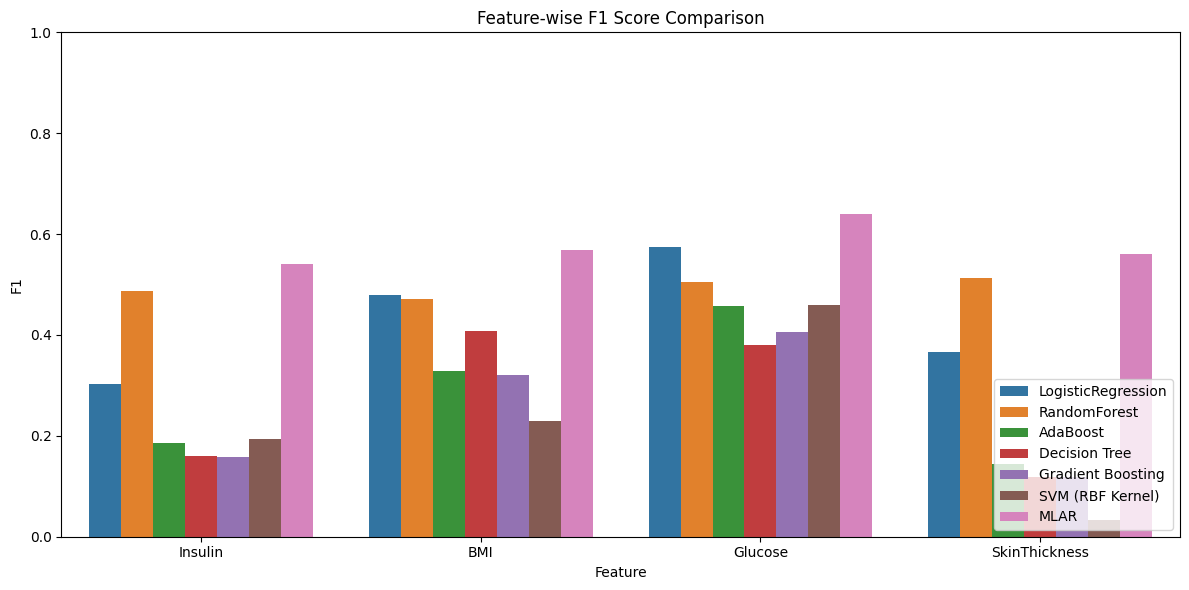

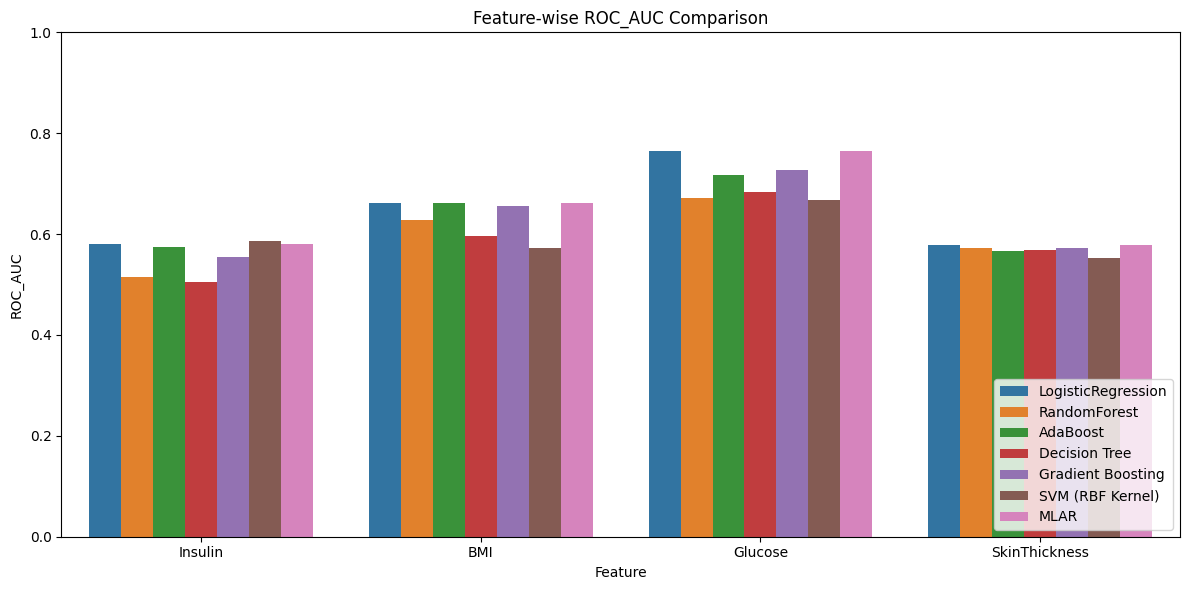


✅ Feature-wise results saved as 'Feature_Wise_Comparison_Results.csv'


In [9]:
# =========================================
# 🔍 Feature-wise Comparison (Per-Feature Modeling)
# =========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Features to test separately
feature_list = ['Insulin', 'BMI', 'Glucose', 'SkinThickness']

# Models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE), random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

# Function to evaluate each single feature
def evaluate_single_feature(feature_name, X, y):
    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Store results
    results = {}

    # Evaluate sklearn models
    for name, model in models.items():
        results[name] = evaluate_model(
            name, model,
            X_train_scaled, y_train,
            X_test_scaled, y_test,
            test_repeats=1000
        )

    # MLAR evaluation
    print(f"\n🔹 Running MLAR for feature: {feature_name}")
    best_params, best_results, W_best, b_best = tune_mlar(
        X_train_scaled, y_train.reshape(-1,1),
        X_test_scaled, y_test.reshape(-1,1),
        param_grid={
            "lr": [0.01, 0.05],
            "epochs": [3000],
            "pos_weight": [1.0, 1.5, 2.0],
            "l2": [0.0, 1e-4]
        },
        verbose=False
    )

    # Retrain MLAR on train data with best params
    W_mlar, b_mlar = MLAR(
        X_train_scaled, y_train.reshape(-1,1),
        lr=best_params["lr"],
        epochs=best_params["epochs"],
        pos_weight=best_params["pos_weight"],
        l2=best_params["l2"]
    )

    y_pred_mlar, y_proba_mlar = predict_mlar(X_test_scaled, W_mlar, b_mlar)
    test_time = measure_test_time(lambda X: predict_mlar(X, W_mlar, b_mlar)[0], X_test_scaled, repeats=5000)

    results["MLAR"] = {
        "Accuracy": accuracy_score(y_test, y_pred_mlar),
        "Precision": precision_score(y_test, y_pred_mlar, zero_division=0),
        "Recall": recall_score(y_test, y_pred_mlar, zero_division=0),
        "F1": f1_score(y_test, y_pred_mlar, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba_mlar),
        "PR_AUC": average_precision_score(y_test, y_proba_mlar),
        "Train Time (s)": np.nan,  # skipping retrain timing for simplicity
        "Test Time (s)": test_time
    }

    return results


# =========================================
# Run for all features
# =========================================
feature_results = {}

for f in feature_list:
    print(f"\n==============================")
    print(f"▶ Evaluating Feature: {f}")
    print(f"==============================")
    X = data[[f]].values
    y = data["Outcome"].values
    feature_results[f] = evaluate_single_feature(f, X, y)


# =========================================
# Combine into a single dataframe
# =========================================
records = []
for feature, models_dict in feature_results.items():
    for model_name, metrics in models_dict.items():
        record = {"Feature": feature, "Model": model_name}
        record.update(metrics)
        records.append(record)

feature_df = pd.DataFrame(records)
feature_df = feature_df.round(5)

print("\n📊 Feature-wise Comparison Summary:\n")
display(feature_df)


# =========================================
# Plot Feature-wise Comparison
# =========================================
plt.figure(figsize=(12,6))
sns.barplot(data=feature_df, x="Feature", y="F1", hue="Model")
plt.title("Feature-wise F1 Score Comparison")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=feature_df, x="Feature", y="ROC_AUC", hue="Model")
plt.title("Feature-wise ROC_AUC Comparison")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Save to CSV for reportb
feature_df.to_csv("Feature_Wise_Comparison_Results.csv", index=False)
print("\n✅ Feature-wise results saved as 'Feature_Wise_Comparison_Results.csv'")


In [12]:
# Run these to inspect shapes and the fitted model
print("X_train_scaled type:", type(X_train_scaled))
print("X_train_scaled shape:", getattr(X_train_scaled, "shape", None))
print("X_test_scaled shape:", getattr(X_test_scaled, "shape", None))

rf = models["RandomForest"]
print("rf is fitted?:", hasattr(rf, "n_features_in_"))
if hasattr(rf, "n_features_in_"):
    print("rf.n_features_in_:", rf.n_features_in_)
else:
    print("rf has not been fitted yet (no n_features_in_)")


X_train_scaled type: <class 'pandas.core.frame.DataFrame'>
X_train_scaled shape: (614, 8)
X_test_scaled shape: (154, 8)
rf is fitted?: True
rf.n_features_in_: 1


In [13]:
from sklearn.inspection import permutation_importance

# 1) Re-fit rf on the correct training data (DataFrame with all columns)
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_estimators=200, n_jobs=-1)
rf.fit(X_train_scaled, y_train)   # ensure X_train_scaled is DataFrame of shape (n_samples, n_features)

# 2) Sanity check
print("rf.n_features_in_ after fit:", rf.n_features_in_, " expected:", X_test_scaled.shape[1])

# 3) Now run permutation importance (use X_test_scaled.values if you still get warnings)
r = permutation_importance(rf, X_test_scaled, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)

feat_names = X_test_scaled.columns if hasattr(X_test_scaled, "columns") else [f"f{i}" for i in range(X_test_scaled.shape[1])]
perm_df = pd.DataFrame({
    "feature": feat_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df


rf.n_features_in_ after fit: 8  expected: 8


,feature,importance_mean,importance_std
1,Glucose,0.040043,0.015374
7,Age,0.011472,0.016486
5,BMI,0.011255,0.020323
2,BloodPressure,0.004545,0.013111
6,DiabetesPedigreeFunction,-0.002165,0.013758
3,SkinThickness,-0.012771,0.010928
4,Insulin,-0.012987,0.018135
0,Pregnancies,-0.014286,0.013967


,feature,f1_single,acc_single
7,Age,0.542056,0.681818
3,SkinThickness,0.513514,0.532468
0,Pregnancies,0.503497,0.538961
4,Insulin,0.496894,0.474026
1,Glucose,0.490196,0.662338
5,BMI,0.466667,0.584416
6,DiabetesPedigreeFunction,0.403846,0.597403
2,BloodPressure,0.396947,0.487013


,feature,f1_drop,acc_drop
5,BMI,0.048605,0.025974
7,Age,0.037358,0.012987
1,Glucose,0.034059,0.019481
2,BloodPressure,0.014059,0.006494
4,Insulin,-0.025941,-0.019481
0,Pregnancies,-0.032203,-0.025974
3,SkinThickness,-0.032203,-0.025974
6,DiabetesPedigreeFunction,-0.060146,-0.025974


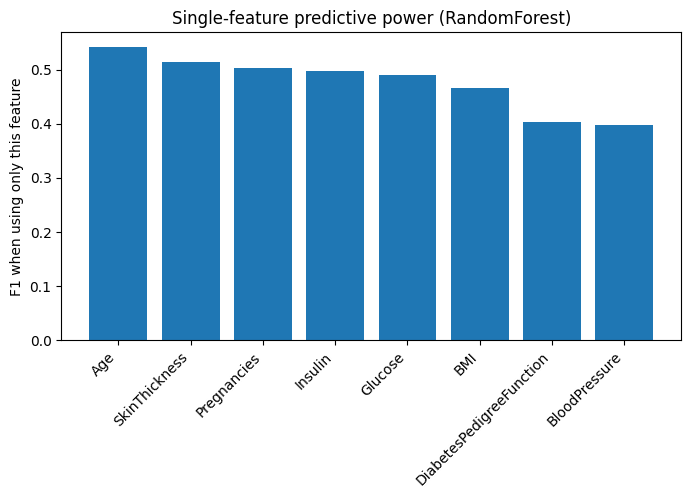

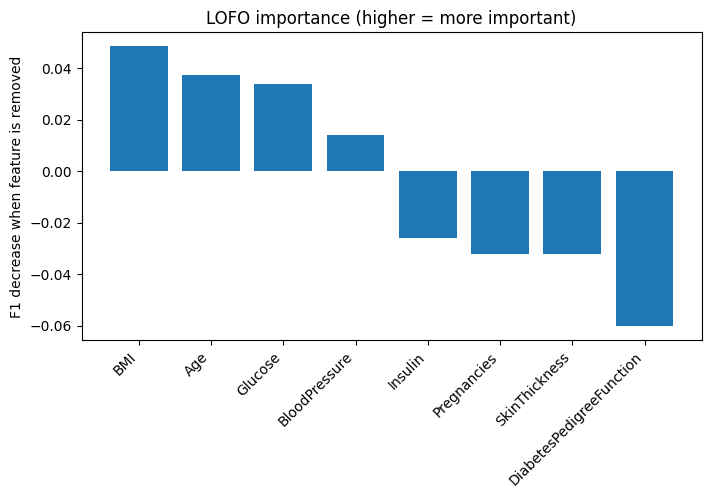

In [14]:
# Cell: Single-feature and LOFO evaluation
from sklearn.base import clone
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_template = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_estimators=200)

features = list(X_train_scaled.columns)

single_scores = []
lofo_scores = []

# baseline full model performance for LOFO comparison
full_model = clone(model_template)
full_model.fit(X_train_scaled, y_train)
full_pred = full_model.predict(X_test_scaled)
full_f1 = f1_score(y_test, full_pred, zero_division=0)
full_acc = accuracy_score(y_test, full_pred)

for feat in features:
    # single-feature
    X_tr_sf = X_train_scaled[[feat]]
    X_te_sf = X_test_scaled[[feat]]
    m = clone(model_template)
    m.fit(X_tr_sf, y_train)
    pred = m.predict(X_te_sf)
    single_scores.append((feat, f1_score(y_test, pred, zero_division=0), accuracy_score(y_test, pred)))
    
    # LOFO
    X_tr_lofo = X_train_scaled.drop(columns=[feat])
    X_te_lofo = X_test_scaled.drop(columns=[feat])
    m2 = clone(model_template)
    m2.fit(X_tr_lofo, y_train)
    pred2 = m2.predict(X_te_lofo)
    lofo_scores.append((feat, full_f1 - f1_score(y_test, pred2, zero_division=0), full_acc - accuracy_score(y_test, pred2)))

single_df = pd.DataFrame(single_scores, columns=["feature","f1_single","acc_single"]).sort_values("f1_single", ascending=False)
lofo_df = pd.DataFrame(lofo_scores, columns=["feature","f1_drop","acc_drop"]).sort_values("f1_drop", ascending=False)

display(single_df)
display(lofo_df)

# Plot single-feature F1
plt.figure(figsize=(8,4))
plt.bar(single_df['feature'], single_df['f1_single'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 when using only this feature")
plt.title("Single-feature predictive power (RandomForest)")
plt.show()

# Plot LOFO: how much F1 drops when we remove the feature
plt.figure(figsize=(8,4))
plt.bar(lofo_df['feature'], lofo_df['f1_drop'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 decrease when feature is removed")
plt.title("LOFO importance (higher = more important)")
plt.show()


In [17]:
import joblib, numpy as np, pandas as pd
scaler = joblib.load("scaler.joblib")
W = np.load("mlar_W.npy")
b = float(np.load("mlar_b.npy")[0])

# replace with the row values you used
row = {
  "Pregnancies": 6,
  "Glucose": 148,
  "BloodPressure": 72,
  "SkinThickness": 35,
  "Insulin": 0,        # note: training used 0->median
  "BMI": 33.6,
  "DiabetesPedigreeFunction": 0.627,
  "Age": 50
}

cols_maybe_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
data = pd.read_csv("PIMA_diabetes_Dataset.csv")
for c in cols_maybe_zero_missing:
    data[c] = data[c].replace(0, np.nan)
medians = {c: float(data[c].median()) for c in cols_maybe_zero_missing}
for c in cols_maybe_zero_missing:
    if row[c] == 0:
        row[c] = medians[c]

FEATURE_ORDER = list(data.drop(columns="Outcome").columns)
x_list = [float(row[col]) for col in FEATURE_ORDER]
for idx, col in enumerate(FEATURE_ORDER):
    if col in ['Insulin','SkinThickness','Glucose','BMI']:
        x_list[idx] = np.log1p(x_list[idx])

X_arr = np.array(x_list).reshape(1,-1)
X_scaled = scaler.transform(X_arr)
z = X_scaled @ W + b
probs = 1/(1+np.exp(-z))
print("X_arr:", X_arr)
print("X_scaled:", X_scaled)
print("z:", z)
print("probs:", probs)


X_arr: [[ 6.          5.00394631 72.          3.58351894  4.83628191  3.54385368
   0.627      50.        ]]
X_scaled: [[0.35294118 0.76549111 0.48979592 0.59550237 0.53730879 0.46517557
  0.24187082 0.48333333]]
z: [[0.49713337]]
probs: [[0.62178543]]


d:\Code\Python deep\FinalCode\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
